# Variational Autoencoder (VAE)

In this notebook, we're going to implement a VAE from the paper [Auto-Encoding Variational Bayes](https://arxiv.org/abs/1312.6114).

The VAE will consist of:
* **An encoder**, which is a network that takes an input $\textbf{x}$ and outputs parameters $\boldsymbol{\mu}$ and $\boldsymbol{\sigma}^2$.
* **A sampler**, which samples a latent representation $\textbf{z} \sim \mathcal{N}(\boldsymbol{\mu}, \boldsymbol{\sigma}^2 \textbf{I})$.
* **A decoder**, which is a network that takes a latent representation $\textbf{z}$ and outputs a reconstruction $\textbf{x}_{recon}$.

We'll be using the MNIST dataset which consists of handwritten digits, so an input $\textbf{x}$ will be an image of a handwritten digit.

Let's get to it!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from tqdm.autonotebook import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Encoder

For the encoder, we'll be using the Gaussian MLP from appendix C.2:

$\textbf{h} = \tanh(\textbf{W}_1 \textbf{x} + \textbf{b}_1$) \
$\boldsymbol{\mu} = \textbf{W}_2 \textbf{h} + \textbf{b}_2$ \
$\log \boldsymbol{\sigma}^2 = \textbf{W}_3 \textbf{h} + \textbf{b}_3$

In [2]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size):
        super(Encoder, self).__init__()
        
        self.input_to_hidden = nn.Linear(input_size, hidden_size)
        self.hidden_to_mu = nn.Linear(hidden_size, latent_size)
        self.hidden_to_logvar = nn.Linear(hidden_size, latent_size)
    
    def forward(self, x):
        h = torch.tanh(self.input_to_hidden(x))
        mu = self.hidden_to_mu(h)
        logvar = self.hidden_to_logvar(h)
        return mu, logvar

## Sampler

The sampler uses the reparameterization trick from section 2.4:

$\textbf{z} = \boldsymbol{\mu} + \boldsymbol{\sigma} \odot \boldsymbol{\epsilon}, \quad$ where $\boldsymbol{\epsilon} \sim \mathcal{N}(\textbf{0}, \textbf{I})$.

In [3]:
def sample(mu, logvar):
    std = torch.exp(logvar / 2)
    eps = torch.rand_like(std)
    return mu + std * eps

## Decoder

For the decoder, we'll be using the Bernoulli MLP from appendix C.1:

$\textbf{h} = \tanh(\textbf{W}_1 \textbf{z} + \textbf{b}_1$) \
$\textbf{x}_{recon} = \sigma(\textbf{W}_2 \textbf{h} + \textbf{b}_2)$

In [4]:
class Decoder(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size):
        super(Decoder, self).__init__()
        
        self.latent_to_hidden = nn.Linear(latent_size, hidden_size)
        self.hidden_to_output = nn.Linear(hidden_size, input_size)
    
    def forward(self, z):
        h = torch.tanh(self.latent_to_hidden(z))
        x_recon = torch.sigmoid(self.hidden_to_output(h))
        return x_recon

## VAE

All right, let's put it all together and build ourselves a VAE!

In [5]:
class VAE(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size):
        super(VAE, self).__init__()
        
        self.encoder = Encoder(input_size, hidden_size, latent_size)
        self.decoder = Decoder(input_size, hidden_size, latent_size)
    
    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = sample(mu, logvar)
        x_recon = self.decoder(z)
        return x_recon, mu, logvar

## Loss

Before we can start training, we need to define a loss function so that we have something to optimize. The loss will be the reconstruction error plus the Kullback–Leibler divergence. We'll not go too deep into this, but basically:

* The reconstruction error measures how close the reconstruction is to the original input, we'll use binary cross entropy for this.
* The Kullback-Leibler divergence acts as regularization, and is derived in appendix B.

In [6]:
def vae_loss(x_recon, x, mu, logvar):
    bce = F.binary_cross_entropy(x_recon, x, reduction='sum')
    kld = -1/2 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return bce + kld

## Data

We'll use the MNIST dataset, which consists of handwritten digits.

In [7]:
batch_size = 100

train_data = datasets.MNIST('data/', train=True, download=True, transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

test_data = datasets.MNIST('data/', train=False, transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

print(f'Loaded {len(train_data)} training images and {len(test_data)} test images.')

Loaded 60000 training images and 10000 test images.


Let's plot some images from the dataset.

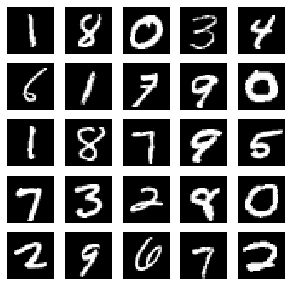

In [8]:
def plot_grid(images, rows, cols):
    fig = plt.figure(figsize=(cols, rows))
    for i, image in enumerate(images, start=1):
        ax = fig.add_subplot(rows, cols, i)
        plt.imshow(image, cmap='gray')
        plt.axis('off')

rows = cols = 5
indices = np.random.choice(np.arange(len(train_data)), rows * cols, replace=False)
images = [train_data[index][0].squeeze() for index in indices]
plot_grid(images, rows, cols)

## Training

Now we're ready to train our VAE. We'll use the Adagrad optimization algorithm since that's what's used in the paper.

In [9]:
input_size = train_data[0][0].flatten().shape[0]
hidden_size = 500
latent_size = 2

vae = VAE(input_size=input_size, hidden_size=hidden_size, latent_size=latent_size).to(device)
optimizer = optim.Adagrad(vae.parameters())

epochs = 15
for epoch in tqdm(range(1, epochs + 1)):
    running_loss = 0
    for batch, (x, _) in tqdm(enumerate(train_loader), total=len(train_loader)):
        x = x.reshape(-1, input_size).to(device)
        
        optimizer.zero_grad()
        x_recon, mu, logvar = vae(x)
        loss = vae_loss(x_recon, x, mu, logvar)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    print(f'Epoch: {epoch}, Loss: {running_loss / len(train_data)}')

torch.save(vae.state_dict(), 'vae.pth')


Epoch: 1, Loss: 186.77869947916668



Epoch: 2, Loss: 173.65820909830728



Epoch: 3, Loss: 170.11288969726562



Epoch: 4, Loss: 167.88339635416668



Epoch: 5, Loss: 166.33671700846355



Epoch: 6, Loss: 165.20498051757812



Epoch: 7, Loss: 164.28116175130208



Epoch: 8, Loss: 163.50727083333334



Epoch: 9, Loss: 162.84825126953126



Epoch: 10, Loss: 162.28708177083334



Epoch: 11, Loss: 161.75767836914062



Epoch: 12, Loss: 161.27585397135417



Epoch: 13, Loss: 160.82371520182292



Epoch: 14, Loss: 160.399723828125



Epoch: 15, Loss: 160.01409965820312



All right, let's reconstruct some random images and see what they look like.

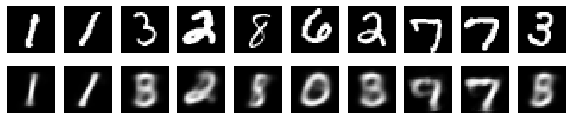

In [10]:
#vae.load_state_dict(torch.load('vae.pth', map_location=device))

cols = 10
indices = np.random.choice(np.arange(len(test_data)), cols, replace=False)
images = [test_data[index][0].squeeze() for index in indices]
with torch.no_grad():
    recon = vae(torch.stack(images).reshape(-1, input_size))[0].reshape(-1, *train_data[0][0].shape[1:])
    recon = [r for r in recon]
plot_grid(images + recon, 2, cols)

Now let's traverse the latent space, plotting decoded samples in a grid!

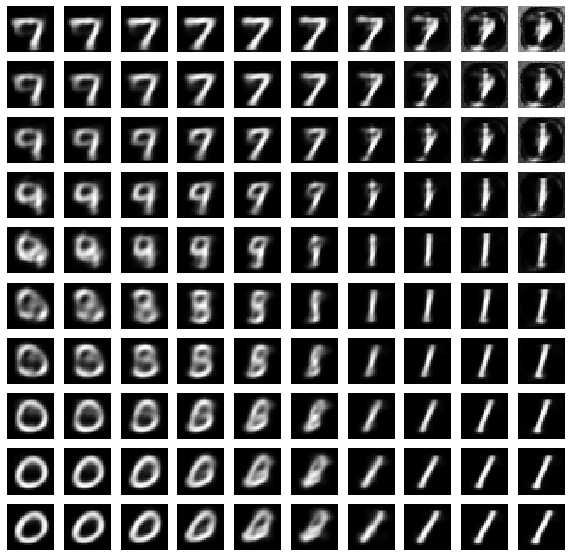

In [11]:
rows = cols = 10
with torch.no_grad():
    a = torch.linspace(-3, 3, rows)
    b = torch.linspace(-3, 3, cols)
    z = torch.stack(torch.meshgrid(a, b), dim=2).reshape(-1, latent_size)
    samples = vae.decoder(z.to(device))
    samples = [sample.reshape(train_data[0][0].shape).squeeze() for sample in samples]
    plot_grid(samples, rows, cols)